In [1]:
from mindvision.dataset import Mnist

# 下载并处理MNIST数据集
download_train = Mnist(path="./MNIST_Data", split="train", batch_size=32, repeat_num=1, shuffle=True, resize=32, download=False)

download_eval = Mnist(path="./MNIST_Data", split="test", batch_size=32, resize=32, download=False)

dataset_train = download_train.run()
dataset_eval = download_eval.run()

[WARNING] ME(20436:2200,MainProcess):2024-04-26-16:40:53.180.926 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(20436:2200,MainProcess):2024-04-26-16:40:53.182.925 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(20436:2200,MainProcess):2024-04-26-16:40:53.183.926 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(20436:2200,MainProcess):2024-04-26-16:40:53.184.919 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW

参数说明：

- path：数据集路径。
- split：数据集类型，支持train、 test、infer，默认为train。
- batch_size：每个训练批次设定的数据大小，默认为32。
- repeat_num：训练时遍历数据集的次数，默认为1。
- shuffle：是否需要将数据集随机打乱（可选参数）。
- resize：输出图像的图像大小，默认为32*32。
- download：是否需要下载数据集，默认为False。

下载的数据集文件的目录结构如下：

```text
./mnist/
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

## 创建模型

按照LeNet的网络结构，LeNet除去输入层共有7层，其中有2个卷积层，2个子采样层，3个全连接层。

![](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/source_zh_cn/beginner/images/lenet.png)

下面是LeNet5网络模型的具体代码实现：

In [2]:
import mindspore.nn as nn

class LeNet5(nn.Cell):
    """
    LeNet-5网络结构
    """
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 卷积层，输入的通道数为num_channel，输出的通道数为6，卷积核大小为5*5
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        # 卷积层，输入的通道数为6，输出的通道数为16，卷积核大小为5*5
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        # 全连接层，输入个数为16*5*5，输出个数为120
        self.fc1 = nn.Dense(16 * 5 * 5, 120)
        # 全连接层，输入个数为120，输出个数为84
        self.fc2 = nn.Dense(120, 84)
        # 全连接层，输入个数为84，分类的个数为num_class
        self.fc3 = nn.Dense(84, num_class)
        # ReLU激活函数
        self.relu = nn.ReLU()
        # 池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # 多维数组展平为一维数组
        self.flatten = nn.Flatten()

    def construct(self, x):
        # 使用定义好的运算构建前向网络
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

network = LeNet5(num_class=10)

同时，MindSpore Vision套件提供了LeNet网络模型接口`lenet`， 定义网络模型如下：

In [3]:
from mindvision.classification.models import lenet

network = lenet(num_classes=10, pretrained=False)

## 定义损失函数和优化器

要训练神经网络模型，需要定义损失函数和优化器函数。

- 损失函数这里使用交叉熵损失函数`SoftmaxCrossEntropyWithLogits`。
- 优化器这里使用`Momentum`。

In [4]:
import mindspore.nn as nn

# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)

## 训练及保存模型

在开始训练之前，MindSpore需要提前声明网络模型在训练过程中是否需要保存中间过程和结果，因此使用`ModelCheckpoint`接口用于保存网络模型和参数，以便进行后续的Fine-tuning（微调）操作。

In [5]:
import mindspore as ms

# 设置模型保存参数，模型训练保存参数的step为1875。
config_ck = ms.CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)

# 应用模型保存参数
ckpoint = ms.ModelCheckpoint(prefix="lenet", directory="./lenet", config=config_ck)

通过MindSpore提供的`model.train`接口可以方便地进行网络的训练，`LossMonitor`可以监控训练过程中`loss`值的变化。

In [6]:
from mindvision.engine.callback import LossMonitor
import mindspore as ms
from mindspore.train.callback import SummaryCollector

summary_collector = SummaryCollector(summary_dir='./summary_dir', collect_freq=1)
# 初始化模型参数
model = ms.Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})

# 训练网络模型，并保存为lenet-1_1875.ckpt文件
model.train(10, dataset_train, callbacks=[ckpoint, LossMonitor(0.01, 1875),summary_collector], dataset_sink_mode=False)


Epoch:[  0/ 10], step:[ 1875/ 1875], loss:[0.034/0.372], time:22.939 ms, lr:0.01000
Epoch time: 32378.114 ms, per step time: 17.268 ms, avg loss: 0.372
Epoch:[  1/ 10], step:[ 1875/ 1875], loss:[0.014/0.064], time:23.934 ms, lr:0.01000
Epoch time: 31224.490 ms, per step time: 16.653 ms, avg loss: 0.064
Epoch:[  2/ 10], step:[ 1875/ 1875], loss:[0.002/0.043], time:25.931 ms, lr:0.01000
Epoch time: 34985.063 ms, per step time: 18.659 ms, avg loss: 0.043
Epoch:[  3/ 10], step:[ 1875/ 1875], loss:[0.033/0.035], time:25.933 ms, lr:0.01000
Epoch time: 34267.831 ms, per step time: 18.276 ms, avg loss: 0.035
Epoch:[  4/ 10], step:[ 1875/ 1875], loss:[0.003/0.026], time:24.931 ms, lr:0.01000
Epoch time: 33017.949 ms, per step time: 17.610 ms, avg loss: 0.026
Epoch:[  5/ 10], step:[ 1875/ 1875], loss:[0.011/0.024], time:29.918 ms, lr:0.01000
Epoch time: 31763.291 ms, per step time: 16.940 ms, avg loss: 0.024
Epoch:[  6/ 10], step:[ 1875/ 1875], loss:[0.000/0.019], time:26.929 ms, lr:0.01000
Epoc

训练过程中会打印loss值，loss值会波动，但总体来说loss值会逐步减小，精度逐步提高。
通过模型运行测试数据集得到的结果，验证模型的泛化能力：

1. 使用`model.eval`接口读入测试数据集。
2. 使用保存后的模型参数进行推理。

In [7]:
acc = model.eval(dataset_eval,callbacks=[summary_collector])

print("{}".format(acc))

{'accuracy': 0.9905849358974359}


可以在打印信息中看出模型精度数据，示例中精度数据达到95%以上，模型质量良好。随着网络迭代次数增加，模型精度会进一步提高。

## 加载模型

In [8]:
import mindspore as ms

# 加载已经保存的用于测试的模型
param_dict = ms.load_checkpoint("./lenet/lenet-1_1875.ckpt")
# 加载参数到网络中
ms.load_param_into_net(network, param_dict)

([],
 ['global_step',
  'learning_rate',
  'momentum',
  'moments.backbone.conv1.weight',
  'moments.backbone.conv2.weight',
  'moments.backbone.fc1.weight',
  'moments.backbone.fc1.bias',
  'moments.backbone.fc2.weight',
  'moments.backbone.fc2.bias',
  'moments.backbone.fc3.weight',
  'moments.backbone.fc3.bias'])

## 验证模型

我们使用生成的模型进行单个图片数据的分类预测，具体步骤如下：

> - 被预测的图片会随机生成，每次运行结果可能会不一样。
> - 代码使用了Tensor模块，阅读更多有关[张量Tensor](https://www.mindspore.cn/tutorials/zh-CN/r1.8/beginner/save_load.html)的信息。

[WARNING] ME(20436:2200,MainProcess):2024-04-26-16:47:12.586.862 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(20436:2200,MainProcess):2024-04-26-16:47:12.587.860 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(20436:2200,MainProcess):2024-04-26-16:47:12.588.858 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(20436:2200,MainProcess):2024-04-26-16:47:12.590.854 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW

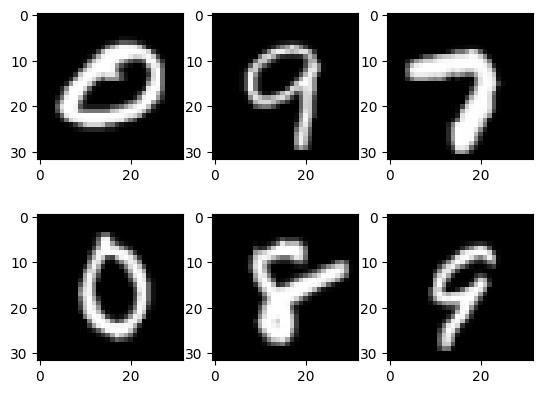

Predicted: "[0 9 7 0 8 9]", Actual: "[0 9 7 0 8 9]"


In [9]:
import numpy as np
import mindspore as ms
import matplotlib.pyplot as plt

mnist = Mnist("./MNIST_Data", split="train", batch_size=6, resize=32)
dataset_infer = mnist.run()
ds_test = dataset_infer.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(ms.Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')

从上面的打印结果可以看出，预测值与目标值完全一致。